In [1]:
'''
Steps:
    1) Divide imput image into patches
    2) Flatten the patches to be handles as tokens
    3) Add classification token at the beginning
    4) Feed tokens into the encoder
    5) Number of output of the encoder is equal to the size of the input
    6) 
'''

'\nSteps:\n    1) Divide imput image into patches\n    2) Flatten the patches to be handles as tokens\n    3) Add classification token at the beginning\n    4) Feed tokens into the encoder\n    5) Number of output of the encoder is equal to the size of the input\n    6) \n'

In [24]:
import torch
import torch.nn as nn 
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from sklearn.model_selection import train_test_split
import numpy as np
from torchsummary import summary
from PIL import Image
import torch.nn.functional as F
from torchvision.datasets import FakeData # Test
from torchvision.transforms import v2
import matplotlib.pyplot as plt

In [2]:
# TODO: LOAD OUR DATA 256X256

VisionTransformerCoinImageClassifier(
  (linear_projection): Linear(in_features=257, out_features=256, bias=True)
)


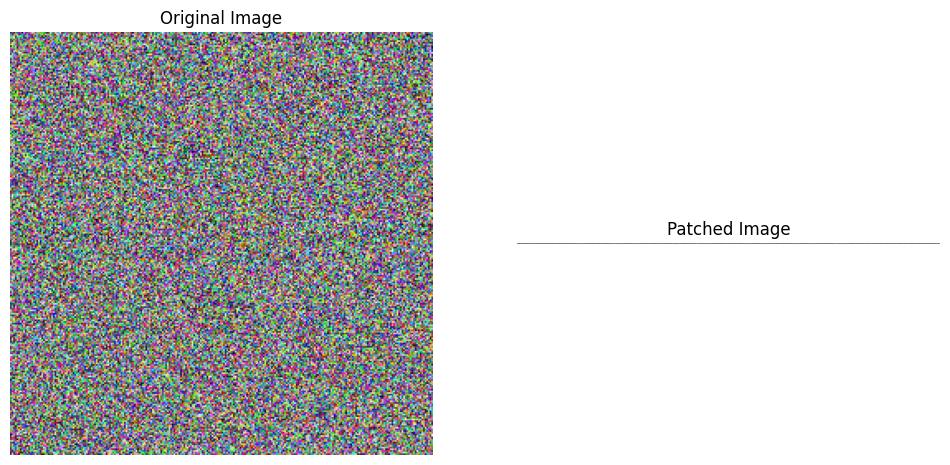

"\nsummary(\n    model=model, \n    input_data=(3, 256, 256), \n    col_names=('output_size','kernel_size','num_params'), \n    verbose=1, # More info = 2\n)\n"

In [78]:
# https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html
# Paper: https://arxiv.org/abs/1706.03762 
# Tutorial: https://www.akshaymakes.com/blogs/vision-transformer
# https://towardsdatascience.com/transformers-explained-visually-part-3-multi-head-attention-deep-dive-1c1ff1024853

def divide_image_into_patches(image, patch_size):
    height, width = image.shape[:2] # Return height and width
    patch_height, patch_width = patch_size
    patches = []

    # Sliding window approach
    for y in range(0, height, patch_height):
        for x in range(0, width, patch_width):
            patch = image[y:y+patch_height, x:x+patch_width]
            patches.append(patch)
    return patches


# ViT class
class VisionTransformerCoinImageClassifier(nn.Module):
    def __init__(
        self, 
        image_size, 
        num_classes,
        num_heads,
        activation,
        num_channels,
        mlp_size,
        embeding_dimension,
        projection_dim,
        patch_size
    ):
        super(VisionTransformerCoinImageClassifier, self).__init__()

        # Calculate the number of patches
        num_patches = (image_size // patch_size) ** 2 

        # Output = patches. + 1 for token
        self.linear_projection = nn.Linear(in_features=num_patches + 1, out_features=embeding_dimension)

        # Positional Encoding
        # self.positional_encoding = 
        self._generate_positional_encoding(num_patches, embeding_dimension)

        # Multihead attention
        self.attention = nn.MultiheadAttention(embed_dim=embeding_dimension, num_heads=num_heads)

        # FFN
        self.feedforward = nn.Sequential(
            nn.Linear(embeding_dimension, mlp_size),
            nn.GELU(),
            nn.Linear(embeding_dimension, mlp_size),
            nn.GELU()
        )

        # Normalization for attention and FFN
        self.norm = nn.LayerNorm(embed_dim, eps=1e-6)



    def forward(self, x, y): # y = class label
        x = x.float()

        # Divide image into patches
        patches = divide_image_into_patches(x, (16,16))

        # Flatten the patches
        flattened_patches = [patch.flatten(start_dim=1) for patch in patches]
        
        # Prepend classification token
        x = torch.cat((y,flattened_patches)) # tensor[[token],[image]]

        # Place input in multiple dimension
        x = self.linear_projection(x)

        # Position the input in the dimension space to create some relation
        x = self.positional_encoding(x) # TODO!!!

        x = self.norm(x)
        x = self.attention(x)
        x = self.norm(x)
        x = feedforward(x)
        
        x = self.norm(x)
        x = self.attention(x)
        x = self.norm(x)
        x = feedforward(x)

        x = self.norm(x)
        x = self.attention(x)
        x = self.norm(x)
        x = feedforward(x)

        return x
    
    def _generate_positional_encoding(self, num_patches, embeding_dimension):
        position = torch.arange(0, num_patches).unsqueeze(1).float() # One long tensor


model = VisionTransformerCoinImageClassifier(
    mlp_size=4096, # FFN 
    image_size=256,
    num_classes=[0,1],
    num_heads=16,
    activation='gelu',
    num_channels=3, # RGB
    embeding_dimension=256, # 16x16
    projection_dim=512, # Each pixel has 2 values 16x16=256 -> 256*2=512 pixel values (x,y)
    patch_size=16 
)

# Get model info of the model
print(model)

# Generate a simple image with different pixel values
image_size = (256, 256)
pixels = np.random.randint(0, 256, size=(image_size[1], image_size[0], 3), dtype=np.uint8)

# Convert patches to a Pillow Image
patched_image = Image.fromarray(np.concatenate(patches, axis=1), 'RGB')

# Visualize the original image beside the patched image
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Display the original image on the left
axes[0].imshow(pixels)
axes[0].set_title('Original Image')
axes[0].axis('off')

# Display the patched image on the right
axes[1].imshow(patched_image)
axes[1].set_title('Patched Image')
axes[1].axis('off')

plt.show()


# Get detailed info of the model
'''
summary(
    model=model, 
    input_data=(3, 256, 256), 
    col_names=('output_size','kernel_size','num_params'), 
    verbose=1, # More info = 2
)
'''